In [ ]:
1. Data preparation: In the data preparation stage, please adopt a comprehensive approach, 
addressing the following areas: 

In [ ]:
1.1. Handle any missing data by identifying and managing incomplete records or missing values 
to ensure the dataset is ready for further analysis.

In [3]:
import pandas as pd
cost = pd.read_csv("cost.csv")
tasks = pd.read_csv("tasks.csv")
suppliers = pd.read_csv("suppliers.csv")

In [ ]:
print(cost.isna().any())
print("\nNumber of missing value per column in the cost.csv file :\n")
print(cost.isna().sum())

print(tasks.isna().any())
print("\nNumber of missing value per column in the tasks.csv file :\n")
print(tasks.isna().sum())

print(suppliers.isna().any())
print("\nNumber of missing value per column in the tasks.csv file :\n")
print(suppliers.isna().sum())

In [ ]:
1.2. Perform relevant feature selection by determining which features are most important for 
your goal. Additionally, apply feature scaling to normalize the data and ensure all features 
contribute equally to the model, avoiding biases due to differing ranges.

In [5]:
# reshape supplier.csv for merging later
suppliers_transposed = suppliers.T
suppliers_transposed.reset_index(drop=True, inplace=True)
suppliers_transposed = suppliers_transposed.iloc[1:].reset_index(drop=True)

supplier_ids = [f'S{i}' for i in range(1, 65)]
suppliers_transposed.insert(0, 'New Column', supplier_ids)

suppliers_transposed.columns = ['Supplier ID', 'SF1', 'SF2', 'SF3', 'SF4', 'SF5', 'SF6', 'SF7', 'SF8', 
              'SF9', 'SF10', 'SF11', 'SF12', 'SF13', 'SF14', 'SF15', 'SF16', 'SF17', 'SF18']
for col in ['SF1', 'SF2', 'SF3', 'SF4', 'SF5', 'SF6', 
            'SF7', 'SF8', 'SF9', 'SF10', 'SF11', 'SF12', 
            'SF13', 'SF14', 'SF15', 'SF16', 'SF17', 'SF18']:
    suppliers_transposed[col] = pd.to_numeric(suppliers_transposed[col], errors='coerce') 

In [743]:
#cost 和 tasks 数据框中的 Task ID 存在差异 lack T9
print(cost['Task ID'].unique())
print(tasks['Task ID'].unique())

['T34' 'T35' 'T36' 'T3' 'T7' 'T8' 'T10' 'T13' 'T16' 'T17' 'T19' 'T20'
 'T26' 'T28' 'T14' 'T21' 'T23' 'T29' 'T1' 'T4' 'T30' 'T6' 'T12' 'T25' 'T5'
 'T2' 'T27' 'T31' 'T33' 'T37' 'T38' 'T39' 'T40' 'T41' 'T42' 'T44' 'T45'
 'T46' 'T47' 'T48' 'T49' 'T50' 'T51' 'T52' 'T53' 'T54' 'T55' 'T56' 'T57'
 'T58' 'T59' 'T60' 'T61' 'T62' 'T63' 'T64' 'T65' 'T66' 'T68' 'T69' 'T70'
 'T72' 'T73' 'T74' 'T75' 'T76' 'T77' 'T78' 'T79' 'T80' 'T81' 'T82' 'T83'
 'T84' 'T85' 'T86' 'T87' 'T88' 'T89' 'T90' 'T91' 'T92' 'T93' 'T94' 'T95'
 'T96' 'T97' 'T98' 'T99' 'T100' 'T101' 'T102' 'T103' 'T104' 'T105' 'T106'
 'T107' 'T108' 'T109' 'T110' 'T111' 'T112' 'T113' 'T114' 'T115' 'T116'
 'T117' 'T118' 'T119' 'T120' 'T121' 'T122' 'T123' 'T124' 'T125' 'T126'
 'T127' 'T128' 'T129' 'T130']
['T1' 'T2' 'T3' 'T4' 'T5' 'T6' 'T7' 'T8' 'T9' 'T10' 'T11' 'T12' 'T13'
 'T14' 'T15' 'T16' 'T17' 'T18' 'T19' 'T20' 'T21' 'T22' 'T23' 'T24' 'T25'
 'T26' 'T27' 'T28' 'T29' 'T30' 'T31' 'T32' 'T33' 'T34' 'T35' 'T36' 'T37'
 'T38' 'T39' 'T40' 'T41' 'T42

In [7]:
#只保留匹配的数据 处理缺失值--删掉
merged_df = pd.merge(cost, tasks, on='Task ID', how='inner')
final_df = pd.merge(merged_df, suppliers_transposed, on='Supplier ID')

In [9]:
final_df['Task ID'] = final_df['Task ID'].str.replace('T', '').astype(int)
final_df['Supplier ID'] = final_df['Supplier ID'].str.replace('S', '').astype(int)

In [11]:
percentage_columns = []

# 遍历每一列
for column in final_df.columns:
    # 检查列中是否有字符串类型的值，并判断是否包含百分号
    if final_df[column].dtype == 'object':  # 只检查字符串类型的列
        if final_df[column].str.contains('%').any():
            percentage_columns.append(column)

print("Columns containing percentage values:", percentage_columns)

Columns containing percentage values: ['TF5', 'TF7']


In [13]:
# 定义清理函数
def clean_percentage(value):
    if isinstance(value, str):
        return float(value.replace('%', ''))
    return value

# 清理识别出的所有带百分号的列
for column in percentage_columns:
    final_df[column] = final_df[column].apply(clean_percentage)
final_df = final_df.astype(float)

In [15]:
#feature selection using RandomForest
# Output variable (target): Supplier ID
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [17]:
X = final_df.drop(columns=['Supplier ID'])  
y = final_df['Supplier ID'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

feature_importances = rf.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'feature': features, 'importance': feature_importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)
print(importance_df)

    feature  importance
134    SF17    0.228204
121     SF4    0.075829
126     SF9    0.071895
129    SF12    0.068578
122     SF5    0.067722
..      ...         ...
10      TF9    0.000000
9       TF8    0.000000
8       TF7    0.000000
17     TF16    0.000000
67     TF66    0.000000

[136 rows x 2 columns]


In [18]:
threshold = 0.01 
selected_features = importance_df[importance_df['importance'] > threshold]
print("Selected features based on importance threshold:\n", selected_features['feature'])

Selected features based on importance threshold:
 134    SF17
121     SF4
126     SF9
129    SF12
122     SF5
127    SF10
133    SF16
125     SF8
124     SF7
120     SF3
123     SF6
135    SF18
118     SF1
119     SF2
132    SF15
131    SF14
128    SF11
130    SF13
Name: feature, dtype: object


In [21]:
#feature normalisation
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

In [23]:
label_encoders = {}
for column in cost.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    cost[column] = label_encoders[column].fit_transform(cost[column])

scaler = preprocessing.MinMaxScaler()
final_df_2=scaler.fit_transform(final_df)
final_df_2

array([[0.25581395, 0.        , 0.47791783, ..., 0.6       , 0.002     ,
        0.75      ],
       [0.25581395, 0.01587302, 0.39663704, ..., 0.6       , 0.002     ,
        0.75      ],
       [0.25581395, 0.03174603, 0.58281356, ..., 0.6       , 0.        ,
        0.75      ],
       ...,
       [1.        , 0.96825397, 0.30815562, ..., 0.6       , 0.3       ,
        0.        ],
       [1.        , 0.98412698, 0.33869233, ..., 0.6       , 0.15      ,
        0.        ],
       [1.        , 1.        , 0.34465954, ..., 0.        , 1.        ,
        1.        ]])

In [43]:
df = pd.DataFrame(final_df_2, columns=final_df.columns)

In [ ]:
1.3. Focus on identifying the top-performing suppliers for each task by analysing the cost data. 
Since not all suppliers perform equally well, you should remove the worst performing 
suppliers from the dataset to make the following tasks more manageable.

In [57]:
df_sorted = df.sort_values(by='Task ID', ascending=True)
df_sorted['Rank'] = df.groupby('Task ID')['Cost'].rank(method='min')
df_sorted_best = df_sorted.query('Rank < 45')

In [53]:
performance = df.groupby(['Task ID', 'Supplier ID'])['Cost'].mean().reset_index()
performance['Rank'] = performance.groupby('Task ID')['Cost'].rank(method='min', ascending=True)
best_suppliers = performance.loc[performance.groupby('Task ID')['Cost'].idxmin()]
best_suppliers

,Task ID,Supplier ID,Cost,Rank
17,0.000000,0.269841,0.182089,1.0
81,0.007752,0.269841,0.280387,1.0
183,0.015504,0.873016,0.072854,1.0
206,0.023256,0.222222,0.170227,1.0
289,0.031008,0.523810,0.353779,1.0
...,...,...,...,...
7374,0.968992,0.222222,0.257841,1.0
7457,0.976744,0.523810,0.277026,1.0
7509,0.984496,0.333333,0.331187,1.0
7610,0.992248,0.920635,0.258247,1.0


In [ ]:
2. Exploratory Data Analysis: (EDA): Consider using various EDA techniques to explore the 
distribution of feature values, cost data and supplier performance:

In [ ]:
2.1. Use EDA methods to analyse the distribution of task features and interpret emerging 
patterns.

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
selected_features = ['SF17', 'SF4', 'SF9', 'SF12', 'SF5', 'SF10', 'SF16', 'SF8', 'SF7', 'SF3', 'SF6', 'SF18', 'SF1', 'SF2', 'SF15', 'SF14', 'SF11', 'SF13']

In [59]:
eda_df = df_sorted_best[selected_features]

In [61]:
print("Numerical data:")
print(eda_df.describe())

Numerical data:
              SF17          SF4          SF9         SF12          SF5  \
count  5280.000000  5280.000000  5280.000000  5280.000000  5280.000000   
mean      0.389878     0.377910     0.501525     0.538880     0.332352   
std       0.390079     0.454411     0.403858     0.405670     0.437198   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.150000     0.000000     0.000000     0.000000     0.000000   
50%       0.300000     0.090909     0.473684     0.571429     0.090909   
75%       1.000000     1.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

              SF10         SF16          SF8          SF7          SF3  \
count  5280.000000  5280.000000  5280.000000  5280.000000  5280.000000   
mean      0.319685     0.534470     0.356971     0.678851     0.504416   
std       0.400016     0.405617     0.430476     0.267902     0.397709   
min       0.000000   

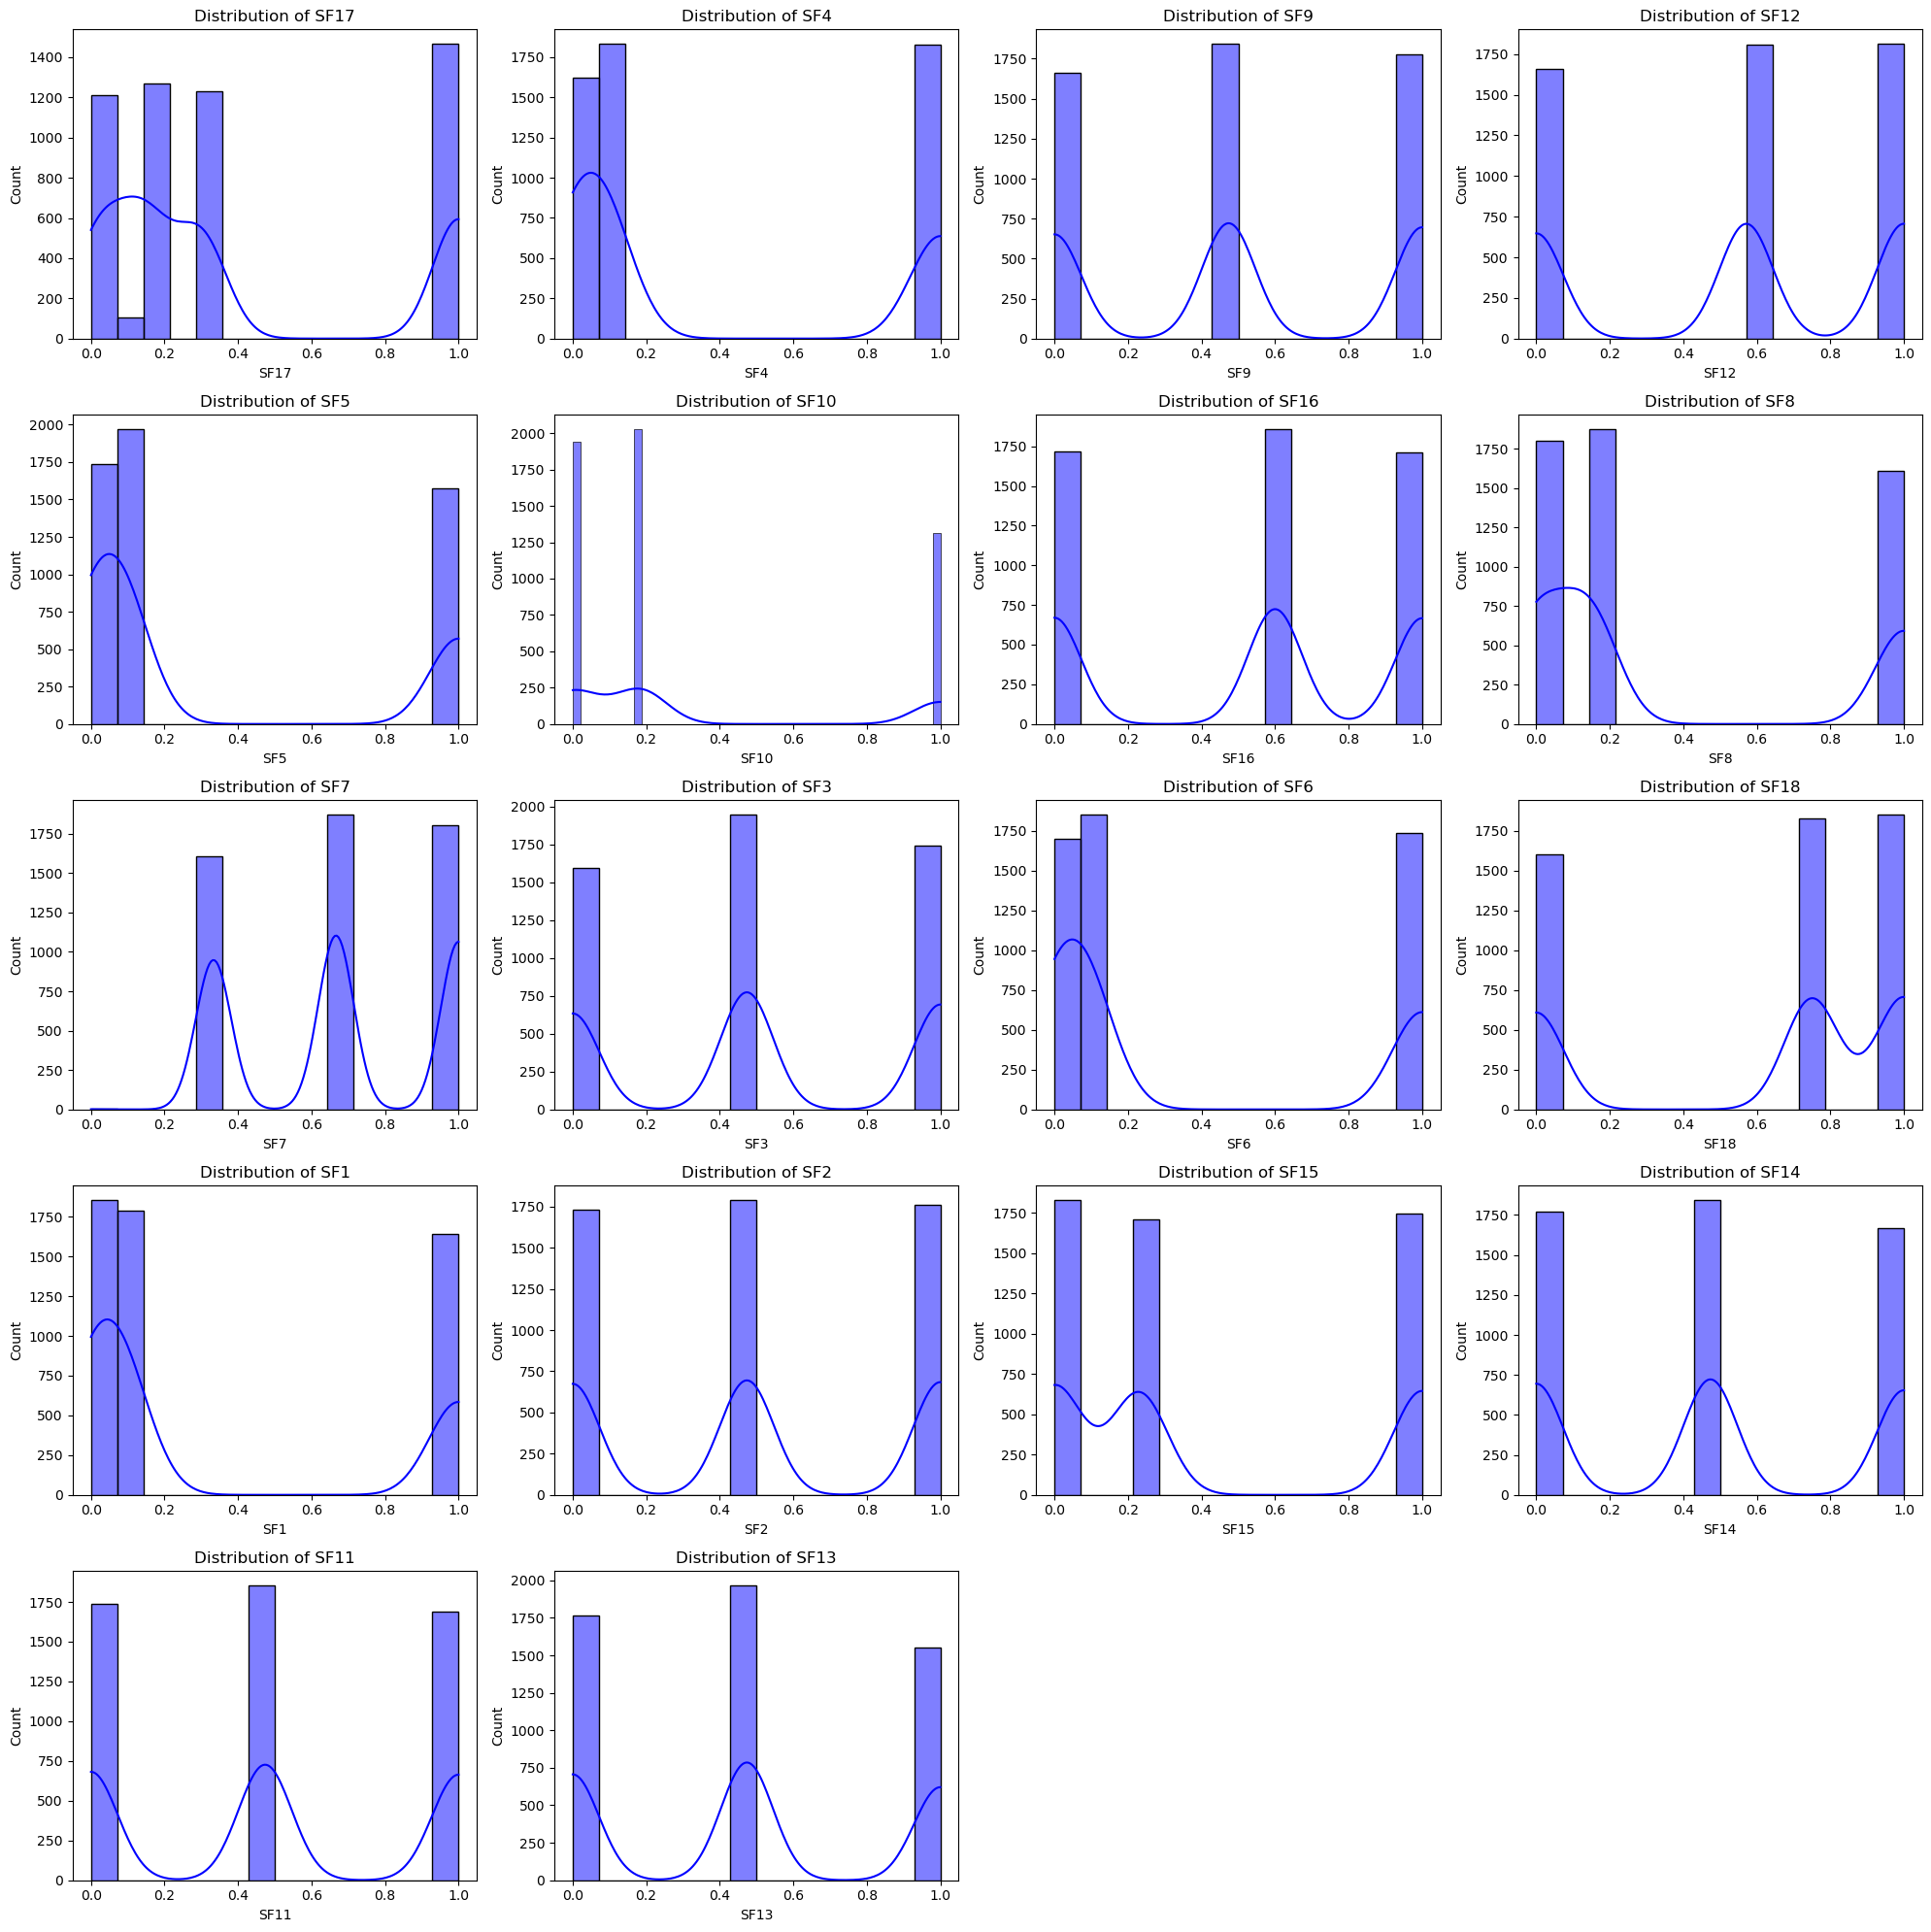

In [63]:
# 绘制数值型特征的直方图
plt.figure(figsize=(20, 20))

for i, column in enumerate(selected_features, 1):
    plt.subplot(5, 4, i) 
    sns.histplot(eda_df[column], kde=True, color='blue')
    plt.title(f'Distribution of {column}', fontsize=12)

plt.tight_layout()
plt.show()

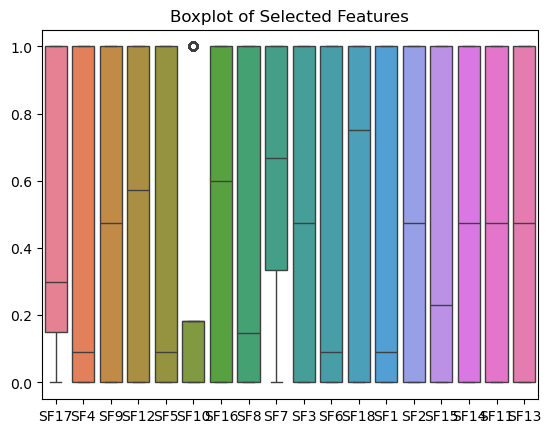

In [65]:
#####绘制数值型特征的box
sns.boxplot(data=eda_df)
plt.title('Boxplot of Selected Features')
plt.show()

Text(0.5, 1.0, 'Correlation Heatmap of Selected Features')

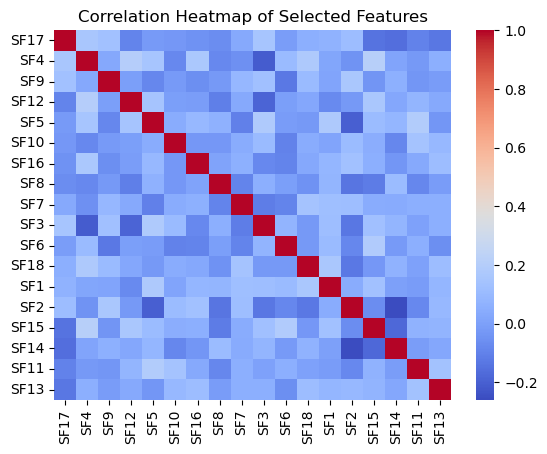

In [67]:
# 计算相关系数矩阵，绘制热图
correlation_matrix = eda_df.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Correlation Heatmap of Selected Features')

In [ ]:
##interpret emerging patterns of  task features
#箱线图解释：SF1 和 SF12 有较高的最大值和一些异常值，这可能表明这些特征在某些情况下有非常高的值。大多数特征的中位数较低，且值的范围相对较小，这可能意味着这些特征在大多数情况下变化不大。
#热图解释：SF1 和 SF12、SF16 和 SF7 之间可能存在强相关性。
#直方图：大多数特征呈现出近似正态分布的形状，即数据在中间值附近集中，两侧逐渐减少。例如，SF2、SF4、SF9和SF10的分布看起来比较对称。
#       有些特征的分布可能显示出偏态。例如，SF17的分布似乎向右偏斜，意味着较高的值比较低的值更常见。
#       有些特征的分布可能显示出偏态。例如，SF17的分布似乎向右偏斜，意味着较高的值比较低的值更常见。
#       某些特征可能显示出多峰分布，例如SF7和SF15，这表明数据可能由两个或多个不同的群体组成。
#       在某些直方图中，特别是在尾部，可能会看到一些异常值。例如，SF1的直方图在左侧有一个小的峰值，这可能表示存在一些异常低的值。。
#       一些特征的值非常集中，例如SF12和SF13，它们的分布非常窄，表明这些特征的值变化不大。
#       其他特征如SF16和SF18的分布较宽，表明这些特征的值在更大的范围内变化。

In [ ]:
2.2. Analyse the cost data to identify patterns and good combinations of tasks and suppliers.

In [69]:
best_suppliers

,Task ID,Supplier ID,Cost,Rank
17,0.000000,0.269841,0.182089,1.0
81,0.007752,0.269841,0.280387,1.0
183,0.015504,0.873016,0.072854,1.0
206,0.023256,0.222222,0.170227,1.0
289,0.031008,0.523810,0.353779,1.0
...,...,...,...,...
7374,0.968992,0.222222,0.257841,1.0
7457,0.976744,0.523810,0.277026,1.0
7509,0.984496,0.333333,0.331187,1.0
7610,0.992248,0.920635,0.258247,1.0


In [ ]:
2.3. Explore how errors (Eq. 1) are distributed across different choices of suppliers, identifying 
key trends or outliers in their performance. Calculate the RMSE (Eq .2) of each supplier for 
all tasks.

In [75]:
X = df_sorted_best[selected_features] 
y = df_sorted_best['Supplier ID'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

RandomForestRegressor(random_state=42)

In [ ]:
predicted_supplier = model.predict(X)

In [1009]:
# 可视化误差分布
plt.figure(figsize=(12, 6))
# 绘制误差的分布
sns.histplot(Errors, bins=30, kde=True)
plt.title('Distribution of Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--')  # 绘制0线
plt.show()

<class 'list'>


In [ ]:
df_sorted_best['Predicted Cost'] = predicted_costs  
df_sorted_best['Errors'] = Errors 

In [ ]:
mse_val = np.mean(squared_Errors)
rmse_val = np.sqrt(mse_val)
TopPerformers['RMSE'] = rmse_val 

In [ ]:
supplier_rmse = TopPerformers.groupby('Supplier ID').apply(
    lambda x: np.sqrt(mean_squared_error(x['Actual Cost'], x['Predicted Cost']))
).reset_index(name='RMSE')

In [ ]:
supplier_rmse_summary = TopPerformers.groupby('Supplier ID')['RMSE'].mean().reset_index()